# Imports

In [ ]:
# install PyArabic library for Arabic preprocessing
!pip install PyArabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 30.9 MB/s 


In [ ]:
# install tensorflow_addons for AdamW optimizer
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.4 MB/s 


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Standard libraries imports
import io
import re
import ast
import math
import gdown
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from lxml import etree
import pyarabic.araby as araby

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

In [ ]:
# read the competition training dataset
train_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara_1000.train', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
train_df = train_df.iloc[:, :2]
# rename the columns
train_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in train_df.columns:
  train_df[col] = train_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
train_df.head(10)

,singular,plural
0,ساحة,ساحات
1,أمر,أمور
2,أمة,أمم
3,جلسة,جلسات
4,ٱتهام,اتهامات
5,وزارة,وزارات
6,ملفة,ملفات
7,مسؤول,مسؤولين
8,خط,خطوط
9,ولاية,ولايات


In [ ]:
# read the competition validation dataset
valid_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.dev', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
valid_df = valid_df.iloc[:, :2]
# rename the columns
valid_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in valid_df.columns:
  valid_df[col] = valid_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
valid_df.head(10)

,singular,plural
0,تهمة,تهم
1,مانع,موانع
2,بعد,أبعاد
3,توظيف,توظيفات
4,خطر,أخطار
5,مسلك,مسالك
6,متحالف,متحالفين
7,فار,فارين
8,بحث,أبحاث
9,نزاع,نزاعات


In [ ]:
# read the competition validation dataset
test_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.gold', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
test_df = test_df.iloc[:, :2]
# rename the columns
test_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in test_df.columns:
  test_df[col] = test_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
test_df.head(10)

,singular,plural
0,طربيد,طوربيدات
1,مولود,مواليد
2,ضروري,ضروريات
3,معني,معنيين
4,جدار,جدران
5,كوليس,كواليس
6,حديقة,حدائق
7,حياة,حيوات
8,دمية,دمى
9,تعاقد,تعاقدات


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hardware Detection

In [ ]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select an appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


# Configs

In [ ]:
# configurations class
class config:

    MAXLEN = 11 # maximum length of sequence

    # model configs
    BATCH_SIZE_PER_REPLICA = 256 # batch size per replica
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size
    EPOCHS = 100 # number of epochs
    LEARNING_RATE = 1E-4 # learning rate
    LEARTING_RATE_REDUCTION_PATIENCE = 10 # number of epochs to weight before lowering LR
    LEARTING_RATE_REDUCTION_FACTOR = 0.2 # LR lowering factor
    BUFFER = 1024 # buffer size for shuffling the training set
    EMBEDDING_SIZE = 256 # embedding size
    NUM_HEADS = 8 # number of heads
    NUM_BLOCKS = 4 # number of encoder blocks
    KEY_DIM = 128 # dimesion of the key, value, and query
    DROPOUT = 0.0 # dopout rate
    SKIP_RATIO = 0.0 # skip connection ratio

# Dataset

In [ ]:
final_unique_char = ['#',
                      'أ',
                      'ف',
                      'ض',
                      'ل',
                      'ا',
                      'ص',
                      'ة',
                      'ب',
                      'ع',
                      'د',
                      'ر',
                      'ي',
                      'و',
                      'ج',
                      'ه',
                      'م',
                      'ث',
                      'ت',
                      'ذ',
                      'ك',
                      'ح',
                      'ى',
                      'ق',
                      'ط',
                      'س',
                      'ش',
                      'ن',
                      'خ',
                      'غ',
                      'ظ',
                      'آ',
                      'إ',
                      'ء',
                      'ز',
                      'ئ',
                      'ؤ',
                      '|']

# list of all Arabic characters
print('Number of Arabic Characters:', len(final_unique_char))

# character to index dictionary
char_to_index = dict((char, index+3) for (index, char) in enumerate(final_unique_char))
# index to character dictionary
index_to_char=  dict((index+3, char) for (index, char) in enumerate(final_unique_char))

char_to_index['$'] = 0 # pad
char_to_index['#'] = 1 # separator
char_to_index['_'] = 2 # mask


index_to_char[0] = '$' # pad
index_to_char[1] = '#' # separator
index_to_char[2] = '_' # mask

Number of Arabic Characters: 38


In [ ]:
all_words = train_df.iloc[:, 0].values.tolist() + train_df.iloc[:, 1].values.tolist()+\
            valid_df.iloc[:, 0].values.tolist() + valid_df.iloc[:, 1].values.tolist()+\
            test_df.iloc[:, 0].values.tolist() + test_df.iloc[:, 1].values.tolist()

all_chars = []
for i in range(len(all_words)):
  all_chars.extend(all_words[i])
all_chars = list(set(list(all_chars)))

In [ ]:
for char in all_chars:
  if char not in final_unique_char:
    print(char)
    new_char = char

ٱ


In [ ]:
char_to_index[new_char] = 8
index_to_char[8] = new_char

In [ ]:
# find maximum token length in both datasets
max_len = 0
# iterate over each column
for i in range(2):
  # iterate over each row
  for j in range(len(train_df)):
    if len(train_df.iloc[j, i]) > max_len:
      max_len = len(train_df.iloc[j, i])
print('Train Max Length:', max_len)

max_len = 0
# iterate over each column
for i in range(2):
  # iterate over each row
  for j in range(len(valid_df)):
    if len(valid_df.iloc[j, i]) > max_len:
      max_len = len(valid_df.iloc[j, i])
print('Valid Max Length:', max_len)

Train Max Length: 11
Valid Max Length: 11


In [ ]:
def text_to_index(lists):
    # construct a list that includes the character-based tokenized input words
    bert_indexed_inputs = []
    
    # iterate over texts
    for text in tqdm(lists):
      try:
        indexes = []
        indexes.append(char_to_index['#']) # special separator token
        temp_list = list(text)
        temp_list.reverse() # reverse list (Arabic from right to left)
        for char in temp_list:
          indexes.append(char_to_index[char]) # append index of each character to the list
        indexes.append(char_to_index['#']) # special separator token
        bert_indexed_inputs.append(indexes)
      except: # if the characters are not in the dictionary continue iterating
          continue
    return bert_indexed_inputs

In [ ]:
def text_to_index_labels(lists):
    # construct a list that includes the character-based tokenized input words
    bert_indexed_inputs = []
    
    for text in tqdm(lists):
      try:
        indexes = []
        indexes.append(char_to_index['#']) # special end token
        temp_list = list(text)
        temp_list.reverse() # reverse list (Arabic from right to left)
        for char in temp_list:
          indexes.append(char_to_index[char]) # append index of each character to the list
        bert_indexed_inputs.append(indexes)
      except: # if the characters are not in the dictionary continue iterating
          continue
    return bert_indexed_inputs

In [ ]:
# convert text to indexes (encoder part)
enc_indexed_text_train = text_to_index(train_df.iloc[:, 0].tolist())
enc_indexed_text_valid = text_to_index(valid_df.iloc[:, 0].tolist())
enc_indexed_text_test = text_to_index(test_df.iloc[:, 0].tolist())
# pad sequences
enc_indexed_text_train = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_train, maxlen=config.MAXLEN, padding='pre')
enc_indexed_text_valid = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_valid, maxlen=config.MAXLEN, padding='pre')
enc_indexed_text_test = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_test, maxlen=config.MAXLEN, padding='pre')
# convert text to indexes (decoder part)
dec_indexed_text_train = text_to_index(train_df.iloc[:, 1].tolist())
dec_indexed_text_valid = text_to_index(valid_df.iloc[:, 1].tolist())
dec_indexed_text_test = text_to_index(test_df.iloc[:, 1].tolist())
# labels for decoder (no start token)
dec_indexed_text_train_labels = text_to_index_labels(train_df.iloc[:, 1].tolist())
dec_indexed_text_valid_labels = text_to_index_labels(valid_df.iloc[:, 1].tolist())
dec_indexed_text_test_labels = text_to_index_labels(test_df.iloc[:, 1].tolist())
# pad sequences
dec_indexed_text_train = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_train, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_valid = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_valid, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_test = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_test, maxlen=config.MAXLEN, padding='pre')
# pad labels
dec_indexed_text_train_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_train_labels, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_valid_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_valid_labels, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_test_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_test_labels, maxlen=config.MAXLEN, padding='pre')

100%|██████████| 600/600 [00:00<00:00, 307050.07it/s]


In [ ]:
# create a TensorFlow training dataset that performs multiple functions including
# shuffling, batching, and prefetching
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_train), tf.constant(dec_indexed_text_train), tf.constant(dec_indexed_text_train_labels)))
train_ds = train_ds.shuffle(config.BUFFER).batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

# create a TensorFlow validation dataset that performs multiple functions including
# batching and prefetching
valid_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_valid), tf.constant(dec_indexed_text_valid), tf.constant(dec_indexed_text_valid_labels)))
valid_ds = valid_ds.batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

# create a TensorFlow test dataset that performs multiple functions including
# batching and prefetching
test_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_test), tf.constant(dec_indexed_text_test), tf.constant(dec_indexed_text_test_labels)))
test_ds = test_ds.batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

len(train_ds), len(valid_ds), len(test_ds)

(4, 2, 3)

# Models

## Pre-trained CBERT

Use the TensorFlow functional API to develop the CBERT model.

In [ ]:
def encoder_block(inputs, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head attention layer
  x = layers.MultiHeadAttention(num_heads=num_heads,
                                  key_dim=key_dim,
                                  dropout=dropout)(inputs, inputs)
  # add & norm
  x = layers.Add()([inputs, x])
  x1 = layers.LayerNormalization()(x)
  # feed-forward
  x = layers.Dense(linear_shape, activation='gelu')(x1)
  x2 = layers.Dense(inputs.shape[-1], activation='linear')(x)
  # add & norm
  x = layers.Add()([x1, x2])
  x = layers.LayerNormalization()(x)
  return x

In [ ]:
with strategy.scope():
  # embedding layer that maps each input character index into a vector of the specified length
  # in the config class
  embedding_layer = layers.Embedding(input_dim=41, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=True)
  # use another trainable embedding layer to learn positional encoding 
  pos_encoding = layers.Embedding(input_dim=41, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=False)

In [ ]:
def encoder_model(inputs, num_blocks=4, num_heads=8, key_dim=64, dropout=0.0, skip_ratio=0.0):

    # embedding layer for characters
    embed = embedding_layer(inputs)
    # trainable positional encoding
    pos_encod = pos_encoding(tf.range(config.MAXLEN))
    # add pos_encod to embeddings
    encoded_embed = embed + pos_encod
    # multi-head attention
    mha = encoder_block(encoded_embed, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    mha = encoder_block(mha, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
    return mha

In [ ]:
def final_model():
  # the full CBERT model
  inputs = layers.Input(shape=(config.MAXLEN,), name='cbert_input')
  bert_output = encoder_model(inputs, num_blocks=config.NUM_BLOCKS, 
                              num_heads=config.NUM_HEADS, key_dim=config.KEY_DIM,
                              dropout=config.DROPOUT, skip_ratio=config.SKIP_RATIO)
  dense = layers.Dense(41, activation='softmax')(bert_output)

  model = tf.keras.Model(inputs=inputs, outputs=dense)
  return model

In [ ]:
# instantiate the model
cbert = final_model()
# load the pre-trained weights
# url = 'https://drive.google.com/uc?export=download&id=1Qus-FZGOscfRDqCyKW2bftCT5tVOLZhK'
# r = requests.get(url, allow_redirects=True)
# open('best_pre_trained_weights.h5', 'wb').write(r.content)
url = 'https://drive.google.com/file/d/1AhVSq3LUZYlPzemlUJoBSw2-4ZsIl0UK/view?usp=sharing'
url = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
output = 'final_cbert_best_weights.h5'
gdown.download(url, output, quiet=False)
cbert.load_weights('/content/final_cbert_best_weights.h5')

# define the input as the original CBERT input, and take the contextualized embeddings
# from the layer before the head
pretrained_encoder = tf.keras.Model(inputs=cbert.input, outputs=cbert.layers[-2].output)
# freeze the model weights during fine-tuning
pretrained_encoder.trainable = False

Downloading...
From: https://drive.google.com/uc?export=download&id=1AhVSq3LUZYlPzemlUJoBSw2-4ZsIl0UK
To: /content/final_cbert_best_weights.h5
100%|██████████| 18.1M/18.1M [00:00<00:00, 29.2MB/s]


## Full Model

In [ ]:
def main_encoder_block(inputs, cbert_output, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs)
  # CBERT-Encoder attention
  cbert_enc_att = layers.MultiHeadAttention(num_heads=num_heads,
                                            key_dim=key_dim,
                                            dropout=dropout)(query=inputs, value=cbert_output, key=cbert_output)
  
  # Drop Net (mean of both MHA layers)
  drop_net = tf.math.reduce_mean([self_att, cbert_enc_att], axis=0)
  # add & norm
  add = layers.Add(name='encoder_add')([inputs, drop_net])
  norm = layers.LayerNormalization()(add)

  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def cbert_encoder_model(inputs, cbert_output):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_encoder_output = main_encoder_block(embed, cbert_output)

  return main_encoder_output

In [ ]:
def main_decoder_block(inputs, cbert_output, main_encoder_output, 
                       attention_mask, num_heads=8, key_dim=64, 
                       dropout=0.0, linear_shape=128):
  # multi-head masked self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs, attention_mask=attention_mask)
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(self_att)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  # add & norm
  add = layers.Add()([self_att, ff])
  self_att_output = layers.LayerNormalization()(add)
  
  # CBERT-Decoder attention
  cbert_dec_att = layers.MultiHeadAttention(num_heads=num_heads,
                                            key_dim=key_dim,
                                            dropout=dropout)(query=self_att_output, 
                                                             value=cbert_output, 
                                                             key=cbert_output)
  # Encoder-Decoder Attention
  enc_dec_att = layers.MultiHeadAttention(num_heads=num_heads,
                                          key_dim=key_dim,
                                          dropout=dropout)(query=self_att_output, value=main_encoder_output, key=main_encoder_output)                                      

  # Drop Net (mean of both MHA layers)
  drop_net = tf.math.reduce_mean([cbert_dec_att, enc_dec_att], axis=0)
  # add & norm
  add = layers.Add()([self_att_output, drop_net])
  norm = layers.LayerNormalization()(add)
 
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def cbert_decoder_model(inputs, cbert_output, main_encoder_output, attention_mask):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_decoder_output = main_decoder_block(embed, cbert_output, main_encoder_output, attention_mask)

  return main_decoder_output

In [ ]:
def final_decoder_output(enc_inputs, dec_inputs, attention_mask):

  cbert_output = pretrained_encoder(enc_inputs)
  x = cbert_encoder_model(enc_inputs, cbert_output)
  x = cbert_decoder_model(dec_inputs, cbert_output, x, attention_mask)
  x = layers.GlobalAveragePooling1D()(x)
  main_dec_output = layers.Dense(41, activation='softmax')(x)
  return main_dec_output

In [ ]:
def encoder_decoder_model():
  # put it all together
  enc_inputs = layers.Input(shape=(config.MAXLEN,), name='enc_input')
  dec_inputs = layers.Input(shape=(config.MAXLEN,), name='dec_input')
  attention_mask = layers.Input(shape=(config.NUM_HEADS, config.MAXLEN, config.MAXLEN,), name='att_mask')

  main_dec_output = final_decoder_output(enc_inputs, dec_inputs, attention_mask)

  model = tf.keras.Model(inputs=[enc_inputs, dec_inputs, attention_mask], outputs=main_dec_output)
  return model

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate the model and print the summary
model = encoder_decoder_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_input (InputLayer)         [(None, 11)]         0           []                               
                                                                                                  
 enc_input (InputLayer)         [(None, 11)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 11, 256)      10496       ['enc_input[0][0]',              
                                                                  'dec_input[0][0]']              
                                                                                                  
 model_1 (Functional)           (None, 11, 256)      4485888     ['enc_input[0][0]']          

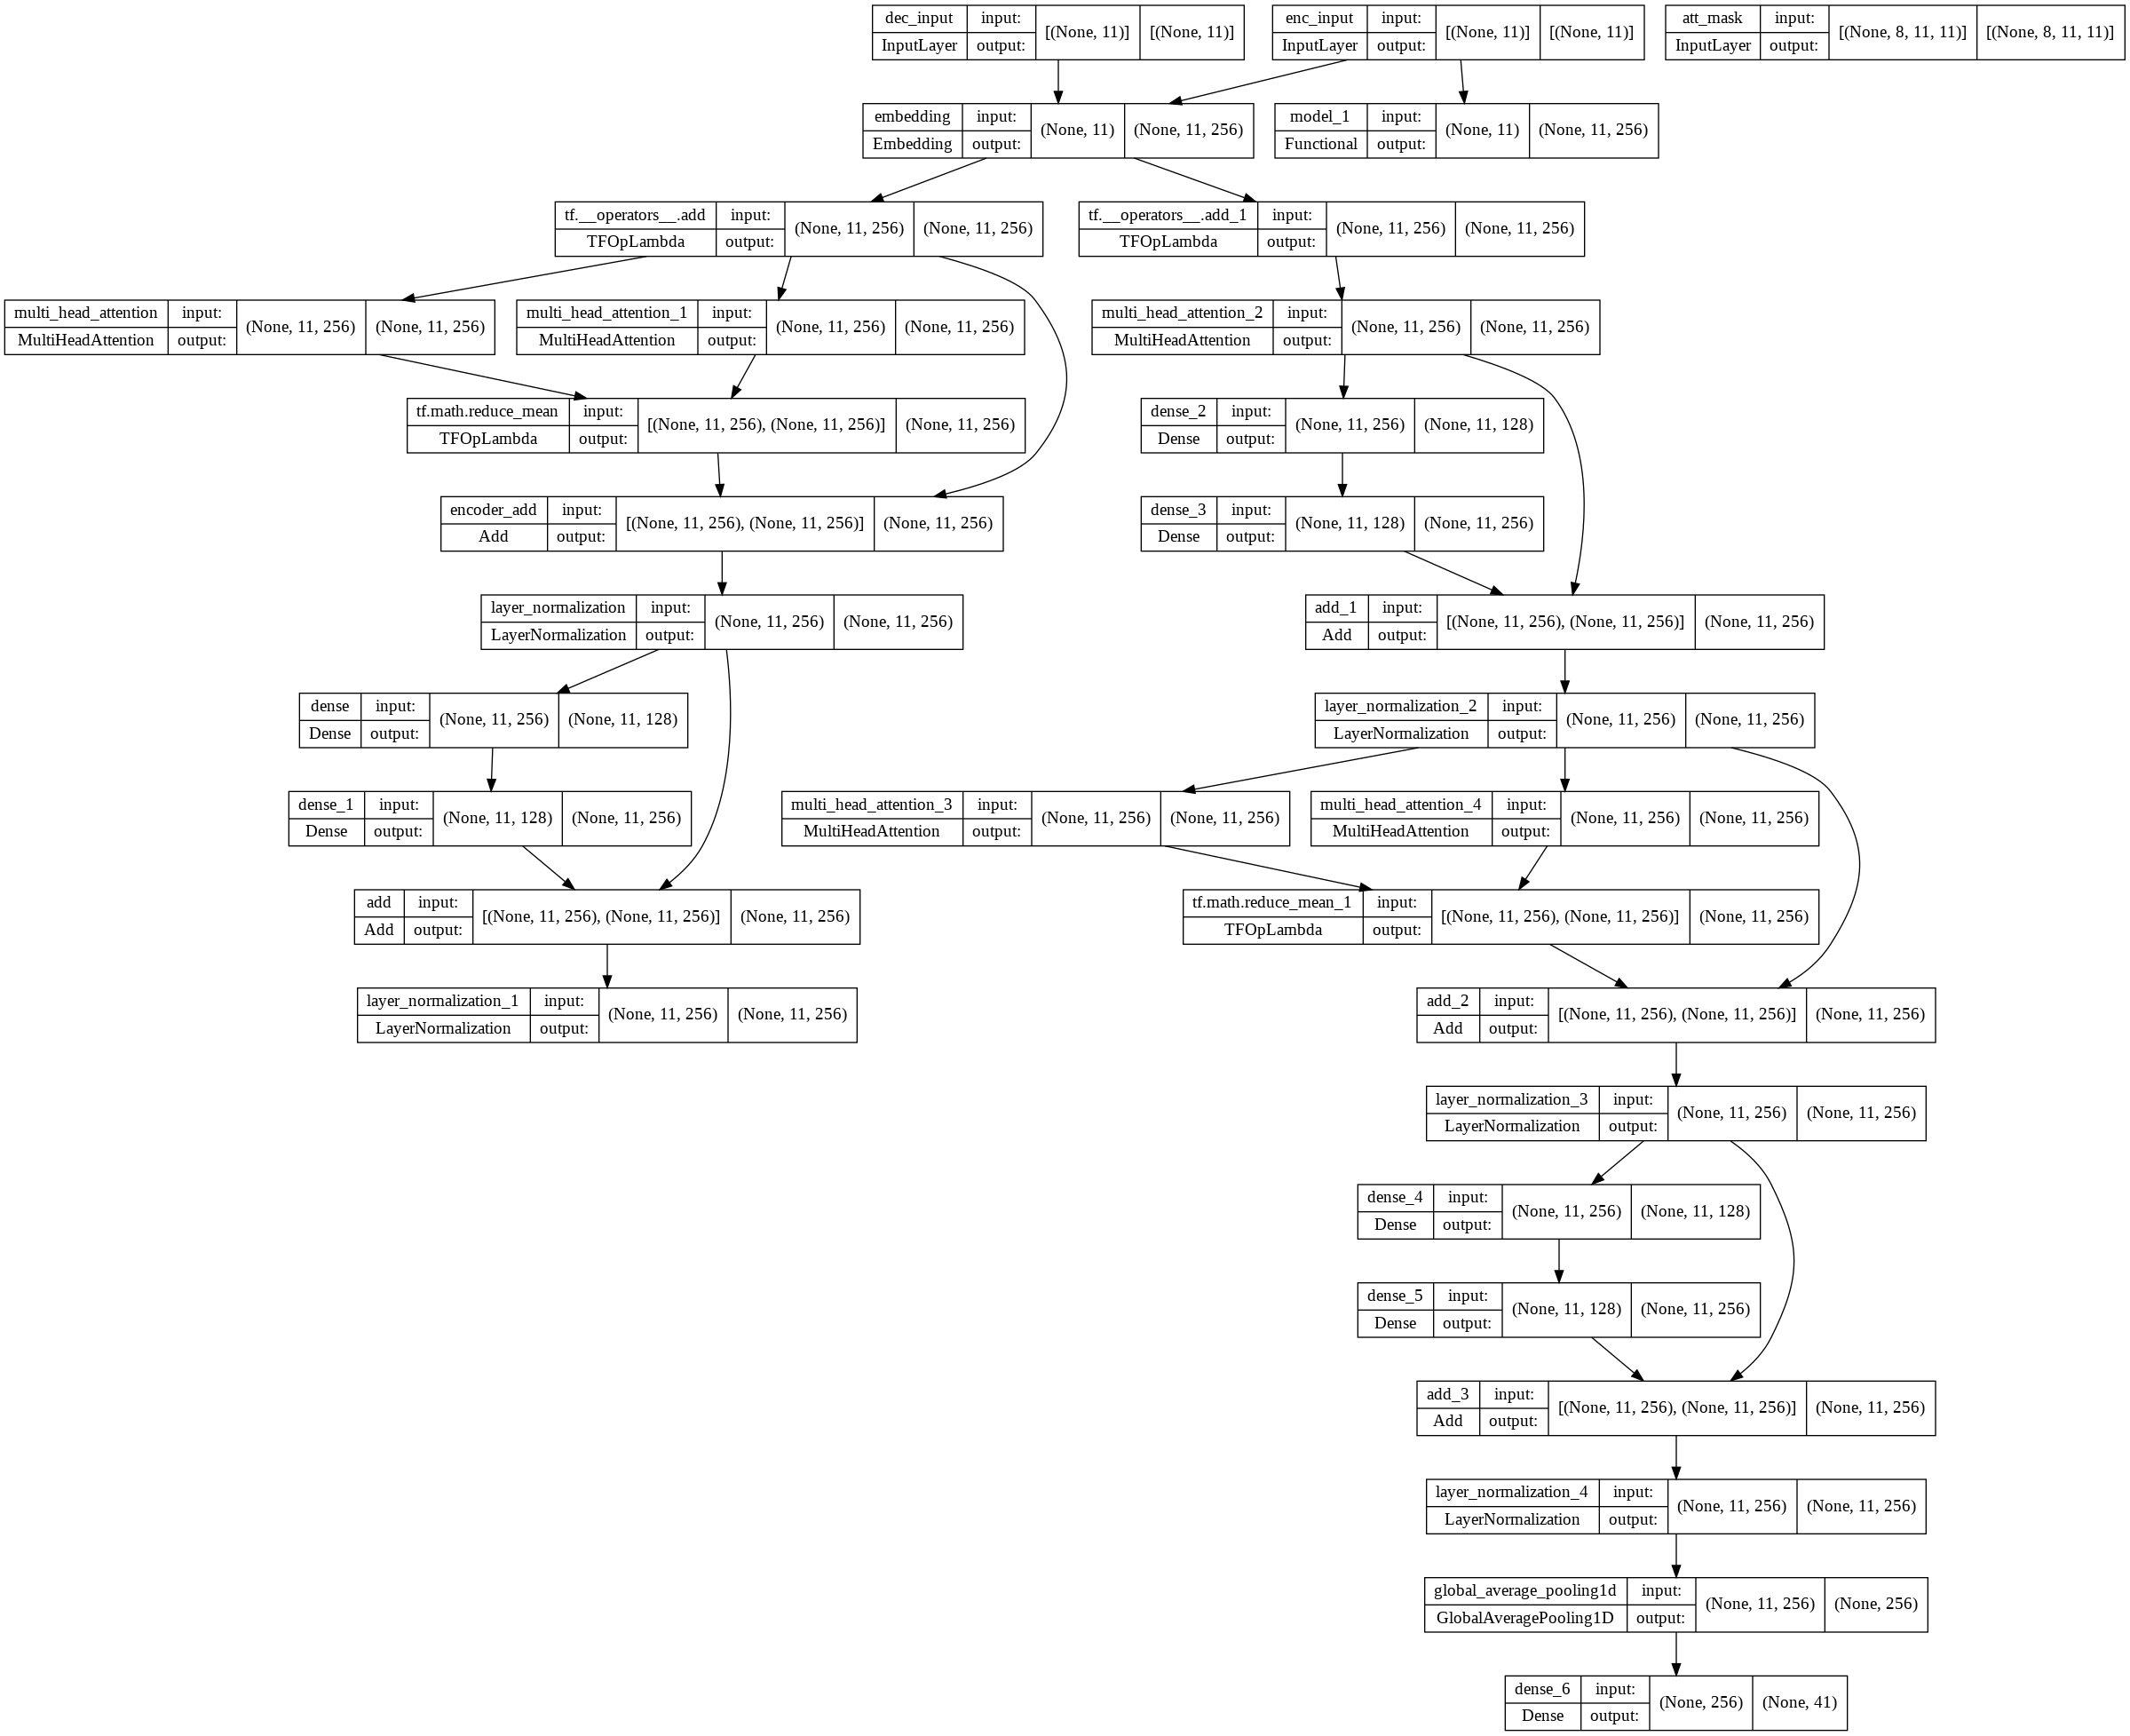

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

# Custom Training

## GPU

In [ ]:
# construct attention masks list
# for each position there a mask that prevents the model from 
# see current and next positions
attention_masks = []
for i in range(1, config.MAXLEN+1):
  # Arabic masking starts from right to left
  attention_mask = [0] * (config.MAXLEN - i) + [1] * i
  attention_masks.append(attention_mask)

In [ ]:
# provide automatic class weights based on the inverse frequency 
# of each token, the more frequent, the less weight
total_num_labels = np.array(dec_indexed_text_train_labels).size
auto_weight_dict = dict()
for i in range(41):
  num_class_examples = (np.array(dec_indexed_text_train_labels) == i).sum()
  if num_class_examples != 0:
    auto_weight_dict[i] = total_num_labels / num_class_examples
  else:
    auto_weight_dict[i] = 0.1

auto_weight_dict[0] = 0.0 # give 'p' zero weight
auto_weight_dict

{0: 0.0,
 1: 11.04417670682731,
 2: 0.1,
 3: 0.1,
 4: 76.92307692307692,
 5: 87.3015873015873,
 6: 261.9047619047619,
 7: 49.549549549549546,
 8: 10.348071495766698,
 9: 132.53012048192772,
 10: 297.2972972972973,
 11: 61.79775280898876,
 12: 63.2183908045977,
 13: 66.66666666666667,
 14: 35.483870967741936,
 15: 26.829268292682926,
 16: 42.96875,
 17: 119.56521739130434,
 18: 148.64864864864865,
 19: 26.634382566585955,
 20: 478.2608695652174,
 21: 17.001545595054097,
 22: 647.0588235294117,
 23: 139.2405063291139,
 24: 91.66666666666667,
 25: 1375.0,
 26: 69.62025316455696,
 27: 132.53012048192772,
 28: 72.8476821192053,
 29: 161.76470588235293,
 30: 32.93413173652694,
 31: 229.16666666666666,
 32: 423.0769230769231,
 33: 733.3333333333334,
 34: 785.7142857142857,
 35: 323.52941176470586,
 36: 289.4736842105263,
 37: 244.44444444444446,
 38: 220.0,
 39: 916.6666666666666,
 40: 0.1}

#### Case 1: Set CBERT to "untrainable" throughout the training process

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets

full_train_losses = []
full_train_accs = []
full_train_top_k_accs = []

full_valid_losses = []
full_valid_accs = []
full_valid_top_k_accs = []

for epoch in range(config.EPOCHS):
    
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  full_train_losses.append(np.mean(losses))
  full_train_accs.append(np.mean(accs))
  full_train_top_k_accs.append(np.mean(top_accs))


  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  full_valid_losses.append(np.mean(losses))
  full_valid_accs.append(np.mean(accs))
  full_valid_top_k_accs.append(np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:15<00:00,  3.81s/it]


Train loss: 133.08774549310857 Train accuracy 0.05956112855876034 Train top 5 accuracy 0.21786833922802049


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 4.527368892322887 Valid accuracy 0.071998269720511 Valid top 5 accuracy 0.20954153551296753
Saving best model wieghts, Accuracy: 0.071998269720511
Epoch: 2/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 119.40262195738879 Train accuracy 0.08463949837129224 Train top 5 accuracy 0.26097178840163077


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Valid loss: 5.136552312157371 Valid accuracy 0.02324361608109691 Valid top 5 accuracy 0.20215557955882765
Accuracy didn't improve from: 0.071998269720511
Epoch: 3/100


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Train loss: 118.8095295916904 Train accuracy 0.09600313435393301 Train top 5 accuracy 0.24608150734142822


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.1274378733201464 Valid accuracy 0.07194724763658913 Valid top 5 accuracy 0.242712007666176
Accuracy didn't improve from: 0.071998269720511
Epoch: 4/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 102.8242968862707 Train accuracy 0.13910658196122808 Train top 5 accuracy 0.33189655196937645


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.0433786348863086 Valid accuracy 0.11062197912145745 Valid top 5 accuracy 0.290107430212877
Saving best model wieghts, Accuracy: 0.11062197912145745
Epoch: 5/100


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Train loss: 92.04388497634368 Train accuracy 0.15869905757294459 Train top 5 accuracy 0.3518808806653727


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.024952845139937 Valid accuracy 0.10968929613855752 Valid top 5 accuracy 0.32610860687087884
Accuracy didn't improve from: 0.11062197912145745
Epoch: 6/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 85.23062619295987 Train accuracy 0.18338558137078176 Train top 5 accuracy 0.3726489073173566


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.489042488011447 Valid accuracy 0.10341358167881315 Valid top 5 accuracy 0.26759853484955703
Accuracy didn't improve from: 0.11062197912145745
Epoch: 7/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 79.64165331287818 Train accuracy 0.17006269736554136 Train top 5 accuracy 0.395768021741374


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Valid loss: 4.922306320884011 Valid accuracy 0.14425981231033802 Valid top 5 accuracy 0.3756183868443424
Saving best model wieghts, Accuracy: 0.14425981231033802
Epoch: 8/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 54.31074586239728 Train accuracy 0.22884012724865566 Train top 5 accuracy 0.480799375355921


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 4.372206178578463 Valid accuracy 0.1472578693858602 Valid top 5 accuracy 0.4048070948232304
Saving best model wieghts, Accuracy: 0.1472578693858602
Epoch: 9/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 64.23209501667456 Train accuracy 0.26175548597662285 Train top 5 accuracy 0.4929467017169703


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.808037161827087 Valid accuracy 0.17999159222976727 Valid top 5 accuracy 0.4290548254820434
Saving best model wieghts, Accuracy: 0.17999159222976727
Epoch: 10/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 48.836467401547864 Train accuracy 0.2676332259804688 Train top 5 accuracy 0.5219435746019537


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 4.132820503278212 Valid accuracy 0.18409580838951198 Valid top 5 accuracy 0.4294099406423894
Saving best model wieghts, Accuracy: 0.18409580838951198
Epoch: 11/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 46.963542900302194 Train accuracy 0.22178683417256584 Train top 5 accuracy 0.4490595636042682


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.369455608454618 Valid accuracy 0.2220052077688954 Valid top 5 accuracy 0.4964672303335233
Saving best model wieghts, Accuracy: 0.2220052077688954
Epoch: 12/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 40.223995173519306 Train accuracy 0.2931034477342936 Train top 5 accuracy 0.4784482687881047


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.373845029960979 Valid accuracy 0.21837243607098406 Valid top 5 accuracy 0.47565839253365993
Accuracy didn't improve from: 0.2220052077688954
Epoch: 13/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 34.93777088685469 Train accuracy 0.30838557946580375 Train top 5 accuracy 0.5109717893329534


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Valid loss: 4.302386869083751 Valid accuracy 0.23878534612330524 Valid top 5 accuracy 0.5027776419777762
Saving best model wieghts, Accuracy: 0.23878534612330524
Epoch: 14/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 30.83017792484977 Train accuracy 0.35579937645657495 Train top 5 accuracy 0.560344828970053


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Valid loss: 4.695389595898715 Valid accuracy 0.21753567491065373 Valid top 5 accuracy 0.44686561314897105
Accuracy didn't improve from: 0.23878534612330524
Epoch: 15/100


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Train loss: 24.177299962802365 Train accuracy 0.3793103439225392 Train top 5 accuracy 0.5564263338561762


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Valid loss: 4.426210064779628 Valid accuracy 0.2625514307821339 Valid top 5 accuracy 0.5048368923704732
Saving best model wieghts, Accuracy: 0.2625514307821339
Epoch: 16/100


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Train loss: 30.47986301644282 Train accuracy 0.35932601912116463 Train top 5 accuracy 0.505877747877755


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.136463717980818 Valid accuracy 0.26619848829101433 Valid top 5 accuracy 0.5041776859963482
Saving best model wieghts, Accuracy: 0.26619848829101433
Epoch: 17/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 26.64635189554908 Train accuracy 0.3828369872221215 Train top 5 accuracy 0.5736677088690075


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 4.613503575325012 Valid accuracy 0.2892237300561233 Valid top 5 accuracy 0.4962794663892551
Saving best model wieghts, Accuracy: 0.2892237300561233
Epoch: 18/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 19.137357679280367 Train accuracy 0.39537617026574234 Train top 5 accuracy 0.5791536011648449


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.203747654503042 Valid accuracy 0.3116754831915552 Valid top 5 accuracy 0.5284254173324867
Saving best model wieghts, Accuracy: 0.3116754831915552
Epoch: 19/100


100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Train loss: 18.675272581252184 Train accuracy 0.4345611252991313 Train top 5 accuracy 0.5885580003430898


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Valid loss: 4.261407909068194 Valid accuracy 0.277896829626777 Valid top 5 accuracy 0.5120554943992333
Accuracy didn't improve from: 0.3116754831915552
Epoch: 20/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 15.806486389853738 Train accuracy 0.43691222136840224 Train top 5 accuracy 0.592476496388289


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 4.1118481592698535 Valid accuracy 0.3385008473626592 Valid top 5 accuracy 0.5561732626096769
Saving best model wieghts, Accuracy: 0.3385008473626592
Epoch: 21/100


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Train loss: 14.633960310708392 Train accuracy 0.4459247595037926 Train top 5 accuracy 0.591692794199017


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.267411865971305 Valid accuracy 0.3423009736632759 Valid top 5 accuracy 0.54691581428051
Saving best model wieghts, Accuracy: 0.3423009736632759
Epoch: 22/100


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Train loss: 13.911128878593445 Train accuracy 0.4431818218224428 Train top 5 accuracy 0.5932601818984206


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.572846767577258 Valid accuracy 0.3098244033753872 Valid top 5 accuracy 0.5095043913884596
Accuracy didn't improve from: 0.3423009736632759
Epoch: 23/100


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Train loss: 15.032621466300704 Train accuracy 0.43769592190669343 Train top 5 accuracy 0.5924764878370545


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.294056607918306 Valid accuracy 0.28461337699131534 Valid top 5 accuracy 0.5350501230833206
Accuracy didn't improve from: 0.3423009736632759
Epoch: 24/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 18.970506226474587 Train accuracy 0.4157523473894054 Train top 5 accuracy 0.5787617538801648


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.395066391338002 Valid accuracy 0.3390437252819538 Valid top 5 accuracy 0.5447953419590538
Accuracy didn't improve from: 0.3423009736632759
Epoch: 25/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 12.853453756733375 Train accuracy 0.44827586179599166 Train top 5 accuracy 0.5952194371176037


100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Valid loss: 4.342133184725588 Valid accuracy 0.3447908501733433 Valid top 5 accuracy 0.5525466115637259
Saving best model wieghts, Accuracy: 0.3447908501733433
Epoch: 26/100


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Train loss: 10.689741026271474 Train accuracy 0.4807993719269606 Train top 5 accuracy 0.5983542296188799


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Valid loss: 4.4613002863797275 Valid accuracy 0.377575591375882 Valid top 5 accuracy 0.5532160238786177
Saving best model wieghts, Accuracy: 0.377575591375882
Epoch: 27/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 9.832816661758857 Train accuracy 0.48589340974153444 Train top 5 accuracy 0.5967868279496377


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 4.523536068471995 Valid accuracy 0.3606995345855301 Valid top 5 accuracy 0.5502587885341861
Accuracy didn't improve from: 0.377575591375882
Epoch: 28/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 10.774618754332716 Train accuracy 0.49059561428359966 Train top 5 accuracy 0.598354235037484


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 4.461114355108955 Valid accuracy 0.3602076768875122 Valid top 5 accuracy 0.5535405249419537
Accuracy didn't improve from: 0.377575591375882
Epoch: 29/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 8.956133795055477 Train accuracy 0.4980407469397919 Train top 5 accuracy 0.599137933162803


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 4.781282789327881 Valid accuracy 0.36170364780859515 Valid top 5 accuracy 0.5463423322547566
Accuracy didn't improve from: 0.377575591375882
Epoch: 30/100


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Train loss: 13.079145148396492 Train accuracy 0.4349529727954756 Train top 5 accuracy 0.5775861994956027


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Valid loss: 4.884237552231008 Valid accuracy 0.3546115784821185 Valid top 5 accuracy 0.5273498748852448
Accuracy didn't improve from: 0.377575591375882
Epoch: 31/100


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Train loss: 22.858234965665773 Train accuracy 0.3977272724309428 Train top 5 accuracy 0.520768024450676


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.555595966902646 Valid accuracy 0.3300597589801658 Valid top 5 accuracy 0.5395502713932232
Accuracy didn't improve from: 0.377575591375882
Epoch: 32/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 11.6484470828013 Train accuracy 0.4784482753073627 Train top 5 accuracy 0.5983542296188799


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.578878408128565 Valid accuracy 0.37162642113187094 Valid top 5 accuracy 0.5579692377624187
Accuracy didn't improve from: 0.377575591375882
Epoch: 33/100


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Train loss: 8.284838511862539 Train accuracy 0.5039184962991964 Train top 5 accuracy 0.6003134776414796


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Valid loss: 4.63361177390272 Valid accuracy 0.37049985050477763 Valid top 5 accuracy 0.5455157739872282
Accuracy didn't improve from: 0.377575591375882
Epoch: 34/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 9.770014933564447 Train accuracy 0.4772727315060117 Train top 5 accuracy 0.5975705314935609


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Valid loss: 4.707634141499346 Valid accuracy 0.35691981711848214 Valid top 5 accuracy 0.5380889988419685
Accuracy didn't improve from: 0.377575591375882
Epoch: 35/100


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Train loss: 9.084888305176388 Train accuracy 0.4549373105507005 Train top 5 accuracy 0.591300943358378


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Valid loss: 4.964199433272535 Valid accuracy 0.3721692924472419 Valid top 5 accuracy 0.5477831939404662
Accuracy didn't improve from: 0.377575591375882
Epoch: 36/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.80808415602554 Train accuracy 0.5148902786472305 Train top 5 accuracy 0.5995297795161605


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Valid loss: 4.797487196597186 Valid accuracy 0.3835982368751006 Valid top 5 accuracy 0.55585896901109
Saving best model wieghts, Accuracy: 0.3835982368751006
Epoch: 37/100


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Train loss: 6.50940575111996 Train accuracy 0.5231191148473457 Train top 5 accuracy 0.6003134776414796


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.86199935186993 Valid accuracy 0.3971211288801648 Valid top 5 accuracy 0.5570610472085801
Saving best model wieghts, Accuracy: 0.3971211288801648
Epoch: 38/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.076094269075177 Train accuracy 0.5242946692319079 Train top 5 accuracy 0.599921631288122


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Valid loss: 4.755061679265716 Valid accuracy 0.3957619020207362 Valid top 5 accuracy 0.5562038763680242
Accuracy didn't improve from: 0.3971211288801648
Epoch: 39/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 6.817678483372385 Train accuracy 0.500000000253997 Train top 5 accuracy 0.599137933162803


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.662365272641182 Valid accuracy 0.37126110087741504 Valid top 5 accuracy 0.5533731730485504
Accuracy didn't improve from: 0.3971211288801648
Epoch: 40/100


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Train loss: 6.78808848017996 Train accuracy 0.49412225440821866 Train top 5 accuracy 0.594827579927038


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Valid loss: 4.924130216240883 Valid accuracy 0.4028539688072421 Valid top 5 accuracy 0.5539466615088962
Saving best model wieghts, Accuracy: 0.4028539688072421
Epoch: 41/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 5.444995744661852 Train accuracy 0.5129310309632935 Train top 5 accuracy 0.5995297795161605


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Valid loss: 4.979874659668315 Valid accuracy 0.3950271824882789 Valid top 5 accuracy 0.5551589471711353
Accuracy didn't improve from: 0.4028539688072421
Epoch: 42/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.672300654378804 Train accuracy 0.501959249546582 Train top 5 accuracy 0.5995297849347646


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.071034507317976 Valid accuracy 0.32636167684739287 Valid top 5 accuracy 0.5435728540813382
Accuracy didn't improve from: 0.4028539688072421
Epoch: 43/100


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Train loss: 9.039834729649805 Train accuracy 0.4737460762685673 Train top 5 accuracy 0.5983542296188799


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 4.831446067853407 Valid accuracy 0.35891376063227654 Valid top 5 accuracy 0.5426544564014132
Accuracy didn't improve from: 0.4028539688072421
Epoch: 44/100


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Train loss: 6.0998054478656165 Train accuracy 0.5219435757872734 Train top 5 accuracy 0.6003134776414796


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.8919840861450545 Valid accuracy 0.40528874251652847 Valid top 5 accuracy 0.558857024223967
Saving best model wieghts, Accuracy: 0.40528874251652847
Epoch: 45/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 4.912969608198512 Train accuracy 0.5368338540535081 Train top 5 accuracy 0.6003134776414796


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.880471975965933 Valid accuracy 0.4060397894883698 Valid top 5 accuracy 0.556224287910895
Saving best model wieghts, Accuracy: 0.4060397894883698
Epoch: 46/100


100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Train loss: 4.385079528797757 Train accuracy 0.5376175575974312 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Valid loss: 4.8789083659648895 Valid accuracy 0.41378085620023985 Valid top 5 accuracy 0.5567161386663263
Saving best model wieghts, Accuracy: 0.41378085620023985
Epoch: 47/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.254485272887078 Train accuracy 0.5333072043616663 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.829143750396642 Valid accuracy 0.4116705860942602 Valid top 5 accuracy 0.5546262723139741
Accuracy didn't improve from: 0.41378085620023985
Epoch: 48/100


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Train loss: 7.677538406781175 Train accuracy 0.4898119042204185 Train top 5 accuracy 0.5956112834709612


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 4.864136179739779 Valid accuracy 0.3739142516119914 Valid top 5 accuracy 0.5519935334609314
Accuracy didn't improve from: 0.41378085620023985
Epoch: 49/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 4.9465362118049105 Train accuracy 0.5121473361822692 Train top 5 accuracy 0.6007053294134411


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.953304076736623 Valid accuracy 0.41142771884121676 Valid top 5 accuracy 0.5549609796567396
Accuracy didn't improve from: 0.41378085620023985
Epoch: 50/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.188488224013285 Train accuracy 0.5474137919531628 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.484905451536179 Valid accuracy 0.3869554932144555 Valid top 5 accuracy 0.545276987451044
Accuracy didn't improve from: 0.41378085620023985
Epoch: 51/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.042467274449089 Train accuracy 0.5317398108203303 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.550294114784761 Valid accuracy 0.4032294943251393 Valid top 5 accuracy 0.5484526030380618
Accuracy didn't improve from: 0.41378085620023985
Epoch: 52/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.671407882124186 Train accuracy 0.495297807353464 Train top 5 accuracy 0.5971786851402033


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.431239953095263 Valid accuracy 0.38807185569947417 Valid top 5 accuracy 0.528729510070248
Accuracy didn't improve from: 0.41378085620023985
Epoch: 53/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 35.336528027599506 Train accuracy 0.2934953028928827 Train top 5 accuracy 0.46669279013506393


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Valid loss: 4.614972022446719 Valid accuracy 0.17647719163108955 Valid top 5 accuracy 0.44353284856135194
Accuracy didn't improve from: 0.41378085620023985
Epoch: 54/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 27.428121264685284 Train accuracy 0.43573667600073596 Train top 5 accuracy 0.5877743022177707


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Valid loss: 4.863722329789942 Valid accuracy 0.2521061912517656 Valid top 5 accuracy 0.4633926845748316
Accuracy didn't improve from: 0.41378085620023985
Epoch: 55/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 7.116468695077029 Train accuracy 0.50705329277976 Train top 5 accuracy 0.599921625869518


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Valid loss: 5.170081362128258 Valid accuracy 0.3956353693184527 Valid top 5 accuracy 0.5637877976352518
Accuracy didn't improve from: 0.41378085620023985
Epoch: 56/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.887759467417544 Train accuracy 0.527037622068416 Train top 5 accuracy 0.5995297849347646


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Valid loss: 5.131836037744176 Valid accuracy 0.41377065161412413 Valid top 5 accuracy 0.5636204440485347
Accuracy didn't improve from: 0.41378085620023985
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 57/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 4.348445776511323 Train accuracy 0.5340909133241936 Train top 5 accuracy 0.599921631288122


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 5.148359099572355 Valid accuracy 0.4165605404837565 Valid top 5 accuracy 0.5600795097310435
Saving best model wieghts, Accuracy: 0.4165605404837565
Epoch: 58/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.9598604169758884 Train accuracy 0.5423197490586475 Train top 5 accuracy 0.599921631288122


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Valid loss: 5.149637100371447 Valid accuracy 0.4150441615757617 Valid top 5 accuracy 0.5613020008260553
Accuracy didn't improve from: 0.4165605404837565
Epoch: 59/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 3.6763484721834008 Train accuracy 0.5446708434346047 Train top 5 accuracy 0.6003134830600836


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.1509523852304975 Valid accuracy 0.4146992552348159 Valid top 5 accuracy 0.5579692369157617
Accuracy didn't improve from: 0.4165605404837565
Epoch: 60/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 3.441613097082485 Train accuracy 0.5474137841639194 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Valid loss: 5.144112811847166 Valid accuracy 0.4180320137265054 Valid top 5 accuracy 0.5572590096430345
Saving best model wieghts, Accuracy: 0.4180320137265054
Epoch: 61/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.2468197423626077 Train accuracy 0.548589342189106 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Valid loss: 5.1537729867480015 Valid accuracy 0.41769730926237325 Valid top 5 accuracy 0.5576039200479334
Accuracy didn't improve from: 0.4180320137265054
Epoch: 62/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.0762647925452753 Train accuracy 0.5505485875024037 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Valid loss: 5.159392767331817 Valid accuracy 0.41891979917206545 Valid top 5 accuracy 0.5579488304528323
Saving best model wieghts, Accuracy: 0.41891979917206545
Epoch: 63/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.925043774260716 Train accuracy 0.5532915390689265 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Valid loss: 5.144036280837926 Valid accuracy 0.42384036985987966 Valid top 5 accuracy 0.5597141926938837
Saving best model wieghts, Accuracy: 0.42384036985987966
Epoch: 64/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.7898077771744947 Train accuracy 0.5564263315702026 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Valid loss: 5.172409111803228 Valid accuracy 0.42418527891012753 Valid top 5 accuracy 0.5600591030987826
Saving best model wieghts, Accuracy: 0.42418527891012753
Epoch: 65/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.6680370941758156 Train accuracy 0.5595611267807808 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.199862457134507 Valid accuracy 0.4240179253234105 Valid top 5 accuracy 0.5598815462806008
Accuracy didn't improve from: 0.42418527891012753
Epoch: 66/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 2.5578250458294693 Train accuracy 0.5611285176128149 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Valid loss: 5.227976366877556 Valid accuracy 0.4233179012821479 Valid top 5 accuracy 0.5593590817668221
Accuracy didn't improve from: 0.42418527891012753
Epoch: 67/100


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Train loss: 2.4576963660391895 Train accuracy 0.5630877710540186 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Valid loss: 5.251211479306221 Valid accuracy 0.42506285706026986 Valid top 5 accuracy 0.5591815249486403
Saving best model wieghts, Accuracy: 0.42506285706026986
Epoch: 68/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 2.366537818854505 Train accuracy 0.5650470114567063 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Valid loss: 5.273888048800555 Valid accuracy 0.42436283437365835 Valid top 5 accuracy 0.5586590589108792
Accuracy didn't improve from: 0.42506285706026986
Epoch: 69/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.2836864163929764 Train accuracy 0.5654388632286679 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Valid loss: 5.294845514676788 Valid accuracy 0.4255955303934487 Valid top 5 accuracy 0.5577814807607369
Saving best model wieghts, Accuracy: 0.4255955303934487
Epoch: 70/100


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Train loss: 2.2091639173979107 Train accuracy 0.566222566772591 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.319734124974771 Valid accuracy 0.425428175621412 Valid top 5 accuracy 0.5583141485059803
Accuracy didn't improve from: 0.4255955303934487
Epoch: 71/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.1439523293890734 Train accuracy 0.5677899657325312 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Valid loss: 5.346855666149747 Valid accuracy 0.42280564169314777 Valid top 5 accuracy 0.5586692621423439
Accuracy didn't improve from: 0.4255955303934487
Epoch: 72/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.0899404771625996 Train accuracy 0.5677899657325312 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.353336949240077 Valid accuracy 0.42331790433011274 Valid top 5 accuracy 0.5586692624810067
Accuracy didn't improve from: 0.4255955303934487
Epoch: 73/100


100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


Train loss: 2.0480866726826537 Train accuracy 0.5681818107312376 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.3715463930910285 Valid accuracy 0.4215321329168298 Valid top 5 accuracy 0.5577814783900976
Accuracy didn't improve from: 0.4255955303934487
Epoch: 74/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.011755418709733 Train accuracy 0.5673981126059185 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.368047647855499 Valid accuracy 0.42097905329005286 Valid top 5 accuracy 0.5570712538266723
Accuracy didn't improve from: 0.4255955303934487
Epoch: 75/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.9656213657422499 Train accuracy 0.5654388672926209 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.383563354611397 Valid accuracy 0.4216994865035469 Valid top 5 accuracy 0.5584712980145757
Accuracy didn't improve from: 0.4255955303934487
Epoch: 76/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.9514604349705307 Train accuracy 0.5662225658412684 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Valid loss: 5.4045959846539935 Valid accuracy 0.42328729057176545 Valid top 5 accuracy 0.5573957511647181
Accuracy didn't improve from: 0.4255955303934487
Epoch: 77/100


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Train loss: 2.3873475403948263 Train accuracy 0.5528996773910794 Train top 5 accuracy 0.599921631288122


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.543179601430893 Valid accuracy 0.42276482470333576 Valid top 5 accuracy 0.5565181703052737
Accuracy didn't improve from: 0.4255955303934487
Epoch: 78/100


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Train loss: 2.1367969148030337 Train accuracy 0.5595611233941533 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.595713879574429 Valid accuracy 0.42645269937135954 Valid top 5 accuracy 0.5581263879483397
Saving best model wieghts, Accuracy: 0.42645269937135954
Epoch: 79/100


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Train loss: 2.004530334337191 Train accuracy 0.5756269555369561 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.6555515419353135 Valid accuracy 0.41848305324939167 Valid top 5 accuracy 0.5570202295414426
Accuracy didn't improve from: 0.42645269937135954
Epoch: 80/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 1.7923107722943479 Train accuracy 0.5748432610522617 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.6115530973131005 Valid accuracy 0.42276482605798676 Valid top 5 accuracy 0.5573957523500378
Accuracy didn't improve from: 0.42645269937135954
Epoch: 81/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.6120586449449712 Train accuracy 0.574451403861696 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Valid loss: 5.590208718722517 Valid accuracy 0.422283175824718 Valid top 5 accuracy 0.5577508659864013
Accuracy didn't improve from: 0.42645269937135954
Epoch: 82/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 1.628263165496967 Train accuracy 0.5752351074056192 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Valid loss: 5.590717551383105 Valid accuracy 0.4210198702798648 Valid top 5 accuracy 0.5580957763913003
Accuracy didn't improve from: 0.42645269937135954
Epoch: 83/100


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Train loss: 1.6414182054048234 Train accuracy 0.5768025067888878 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 5.607244316827167 Valid accuracy 0.41926471127027815 Valid top 5 accuracy 0.5584508900276639
Accuracy didn't improve from: 0.42645269937135954
Epoch: 84/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.6265692975033412 Train accuracy 0.5764106604355302 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.60729935223406 Valid accuracy 0.4210096643390981 Valid top 5 accuracy 0.5596733785827052
Accuracy didn't improve from: 0.42645269937135954
Epoch: 85/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.6126848357644947 Train accuracy 0.5764106604355302 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Valid loss: 5.6148088140921155 Valid accuracy 0.41925450532951136 Valid top 5 accuracy 0.5601856386796995
Accuracy didn't improve from: 0.42645269937135954
Epoch: 86/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.5946345620534637 Train accuracy 0.5779780512675643 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Valid loss: 5.628645173527977 Valid accuracy 0.41996473260223866 Valid top 5 accuracy 0.5587855933064764
Accuracy didn't improve from: 0.42645269937135954
Epoch: 87/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.5658285705880686 Train accuracy 0.5799372992901639 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Valid loss: 5.639835279096257 Valid accuracy 0.4215321302075278 Valid top 5 accuracy 0.5572079895910892
Accuracy didn't improve from: 0.42645269937135954
Epoch: 88/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.5257187565280632 Train accuracy 0.5818965473127636 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Valid loss: 5.660550152713602 Valid accuracy 0.4192034823989326 Valid top 5 accuracy 0.5557977396317504
Accuracy didn't improve from: 0.42645269937135954
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 89/100


100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Train loss: 1.266800076700747 Train accuracy 0.5795454515821554 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


Valid loss: 5.736868320540949 Valid accuracy 0.40940316224640066 Valid top 5 accuracy 0.5519527191804214
Accuracy didn't improve from: 0.42645269937135954
Epoch: 90/100


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Train loss: 1.221883196045052 Train accuracy 0.5803291469981725 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.727937667207285 Valid accuracy 0.40853578732772305 Valid top 5 accuracy 0.5514200487258759
Accuracy didn't improve from: 0.42645269937135954
Epoch: 91/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.2054991256445646 Train accuracy 0.5807209987701341 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Valid loss: 5.742293747988614 Valid accuracy 0.40484791503033857 Valid top 5 accuracy 0.5500200006433509
Accuracy didn't improve from: 0.42645269937135954
Epoch: 92/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.1924769975752993 Train accuracy 0.5811128505420956 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.738692045211792 Valid accuracy 0.40467035821215674 Valid top 5 accuracy 0.5494975361295722
Accuracy didn't improve from: 0.42645269937135954
Epoch: 93/100


100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


Train loss: 1.18009872531349 Train accuracy 0.5811128505420956 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.720827687870372 Valid accuracy 0.4069479803808711 Valid top 5 accuracy 0.5507200246846135
Accuracy didn't improve from: 0.42645269937135954
Epoch: 94/100


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Train loss: 1.168061093681238 Train accuracy 0.5811128505420956 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.719631478190422 Valid accuracy 0.40783576447178016 Valid top 5 accuracy 0.5508975815027952
Accuracy didn't improve from: 0.42645269937135954
Epoch: 95/100


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Train loss: 1.1562789363617247 Train accuracy 0.5811128505420956 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Valid loss: 5.712582922794602 Valid accuracy 0.4088806962086396 Valid top 5 accuracy 0.5515976028347557
Accuracy didn't improve from: 0.42645269937135954
Epoch: 96/100


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Train loss: 1.144704650918191 Train accuracy 0.5811128505420956 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Valid loss: 5.713322054256093 Valid accuracy 0.40923580984500324 Valid top 5 accuracy 0.551075138320977
Accuracy didn't improve from: 0.42645269937135954
Epoch: 97/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.1333104019815272 Train accuracy 0.5815047023140572 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Valid loss: 5.716127044775269 Valid accuracy 0.4097582758827643 Valid top 5 accuracy 0.5512526951391589
Accuracy didn't improve from: 0.42645269937135954
Epoch: 98/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.1220789478075774 Train accuracy 0.5818965486674146 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.722393604842099 Valid accuracy 0.4095807190645825 Valid top 5 accuracy 0.5514302519573406
Accuracy didn't improve from: 0.42645269937135954
Epoch: 99/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.1109976777806878 Train accuracy 0.5826802467927337 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.725243503397161 Valid accuracy 0.4097582758827643 Valid top 5 accuracy 0.5516078087755225
Accuracy didn't improve from: 0.42645269937135954
Epoch: 100/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 1.10005848092789 Train accuracy 0.5830720985646952 Train top 5 accuracy 0.6010971757667986


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

Valid loss: 5.736571847037836 Valid accuracy 0.4095807190645825 Valid top 5 accuracy 0.5516078087755225
Accuracy didn't improve from: 0.42645269937135954


In [ ]:
# build a dataframe and populate it the training history
pd.DataFrame({'full_train_losses':full_train_losses,
              'full_train_accs': full_train_accs,
              'full_train_top_k_accs': full_train_top_k_accs,
              'full_valid_losses':full_valid_losses,
              'full_valid_accs': full_valid_accs,
              'full_valid_top_k_accs': full_valid_top_k_accs}).to_csv('final_validation_set_train_progress_fused_case_1.csv', index=False)

!mv /content/final_validation_set_train_progress_fused_case_1.csv /content/drive/MyDrive/NLP_Course

#### Prediction (Validation)

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')
    
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(valid_results)

100%|██████████| 2/2 [00:10<00:00,  5.11s/it]

{'loss': 5.594527721405029, 'sparse_categorical_accuracy': 0.4285714328289032, 'top_k_acc': 0.5587065815925598}


In [ ]:
# save the predictions as a NumPy array
np.save('final_validation_set_prediction_fused_case_1.npy', final_full_sequence_preds)
!mv /content/final_validation_set_prediction_fused_case_1.npy /content/drive/MyDrive/NLP_Course

#### Prediction (Test)

In [ ]:
# iterate over the test dataset
for iteration, batch in enumerate(tqdm(test_ds, total=len(test_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    test_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(test_results)

100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

{'loss': 5.599582195281982, 'sparse_categorical_accuracy': 0.41800829768180847, 'top_k_acc': 0.5549021363258362}


In [ ]:
# save the predictions as a NumPy array
np.save('final_test_set_prediction_fused_case_1.npy', final_full_sequence_preds)
!mv /content/final_test_set_prediction_fused_case_1.npy /content/drive/MyDrive/NLP_Course

#### Case 2: Set CBERT to "untrainable" during the first 50 epochs then set it to "trainable"

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  if epoch == 50:
    print('*'*70)
    print(f'Fine-tuning all layers with LR = {5e-5}')
    model.trainable = True
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=metrics,
                  optimizer=tfa.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.0))
    
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


Train loss: 137.69771152734756 Train accuracy 0.05054858826439489 Train top 5 accuracy 0.18847962418063122


100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


Valid loss: 4.6496031934564765 Valid accuracy 0.049830198795958 Valid top 5 accuracy 0.16008686054159293
Saving best model wieghts, Accuracy: 0.049830198795958
Epoch: 2/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 125.41802966323766 Train accuracy 0.09678683353757317 Train top 5 accuracy 0.2836990595202554


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


Valid loss: 4.781753052364696 Valid accuracy 0.02374567345462062 Valid top 5 accuracy 0.21939287808808414
Accuracy didn't improve from: 0.049830198795958
Epoch: 3/100


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Train loss: 121.194800124927 Train accuracy 0.09404388891363685 Train top 5 accuracy 0.24921629996970296


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 4.864002368666909 Valid accuracy 0.0684369287707589 Valid top 5 accuracy 0.24576108631762592
Saving best model wieghts, Accuracy: 0.0684369287707589
Epoch: 4/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 107.81607568264008 Train accuracy 0.16183385608548467 Train top 5 accuracy 0.3679467095485465


100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


Valid loss: 5.2136310338974 Valid accuracy 0.039521698585965416 Valid top 5 accuracy 0.2278033583001657
Accuracy didn't improve from: 0.0684369287707589
Epoch: 5/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 98.5409147333015 Train accuracy 0.09639498477124354 Train top 5 accuracy 0.2731191248802299


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.196542338891462 Valid accuracy 0.0807332479479638 Valid top 5 accuracy 0.2957831263880838
Saving best model wieghts, Accuracy: 0.0807332479479638
Epoch: 6/100


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Train loss: 79.05323552001606 Train accuracy 0.17672413752668284 Train top 5 accuracy 0.4071316661059179


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.371285709467801 Valid accuracy 0.11242816072296012 Valid top 5 accuracy 0.31447148915718903
Saving best model wieghts, Accuracy: 0.11242816072296012
Epoch: 7/100


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Train loss: 72.09849055517803 Train accuracy 0.21081504505127668 Train top 5 accuracy 0.45141065742989833


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.057599208571694 Valid accuracy 0.09327855587682941 Valid top 5 accuracy 0.30972848392345687
Accuracy didn't improve from: 0.11242816072296012
Epoch: 8/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 62.53914958238602 Train accuracy 0.2182601890526712 Train top 5 accuracy 0.42789968657730654


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 4.834811741655523 Valid accuracy 0.1390249485319311 Valid top 5 accuracy 0.41241142424670135
Saving best model wieghts, Accuracy: 0.1390249485319311
Epoch: 9/100


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Train loss: 51.92957340451804 Train accuracy 0.27664576716382394 Train top 5 accuracy 0.5278213154101237


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.849229205738414 Valid accuracy 0.14376183751631866 Valid top 5 accuracy 0.36703034795143386
Saving best model wieghts, Accuracy: 0.14376183751631866
Epoch: 10/100


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Train loss: 45.99403266337785 Train accuracy 0.28017241279171273 Train top 5 accuracy 0.5352664570832117


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.16325464031913 Valid accuracy 0.17029331522909077 Valid top 5 accuracy 0.42883236706256866
Saving best model wieghts, Accuracy: 0.17029331522909077
Epoch: 11/100


100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Train loss: 34.67064140330661 Train accuracy 0.3201410655694252 Train top 5 accuracy 0.5626959288916127


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 5.1405128836631775 Valid accuracy 0.21151915226470341 Valid top 5 accuracy 0.45739656568250875
Saving best model wieghts, Accuracy: 0.21151915226470341
Epoch: 12/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 49.01254359937527 Train accuracy 0.28409090595827863 Train top 5 accuracy 0.4753134849650616


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.9166681658137925 Valid accuracy 0.19701663878830997 Valid top 5 accuracy 0.4348427655005997
Accuracy didn't improve from: 0.21151915226470341
Epoch: 13/100


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Train loss: 34.18321111256426 Train accuracy 0.3119122248820283 Train top 5 accuracy 0.539184953128411


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 4.890123226425865 Valid accuracy 0.26396167870949616 Valid top 5 accuracy 0.4940324601801959
Saving best model wieghts, Accuracy: 0.26396167870949616
Epoch: 14/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 23.55583189834248 Train accuracy 0.38910657582296565 Train top 5 accuracy 0.5897335418161344


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Valid loss: 5.026141275059093 Valid accuracy 0.22396853904832492 Valid top 5 accuracy 0.48430765081535687
Accuracy didn't improve from: 0.26396167870949616
Epoch: 15/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 22.755074261941694 Train accuracy 0.3989028224975548 Train top 5 accuracy 0.5893416927534748


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.077919943766161 Valid accuracy 0.2591472368010066 Valid top 5 accuracy 0.4938038804314353
Accuracy didn't improve from: 0.26396167870949616
Epoch: 16/100


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Train loss: 38.34993847527287 Train accuracy 0.3389498452147977 Train top 5 accuracy 0.5666144308634102


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.177511383186687 Valid accuracy 0.25238579511642456 Valid top 5 accuracy 0.49006498249417
Accuracy didn't improve from: 0.26396167870949616
Epoch: 17/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 19.39362166144631 Train accuracy 0.3922413801351054 Train top 5 accuracy 0.584247649520297


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.083072014830329 Valid accuracy 0.27331096458841453 Valid top 5 accuracy 0.529992813244462
Saving best model wieghts, Accuracy: 0.27331096458841453
Epoch: 18/100


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Train loss: 15.93660216439854 Train accuracy 0.429075230801986 Train top 5 accuracy 0.5952194368212738


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.009510872038928 Valid accuracy 0.30998155068267474 Valid top 5 accuracy 0.5366583370010961
Saving best model wieghts, Accuracy: 0.30998155068267474
Epoch: 19/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 14.834249611605298 Train accuracy 0.4212382451885126 Train top 5 accuracy 0.5956112885932353


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.031570301814512 Valid accuracy 0.2802254781126976 Valid top 5 accuracy 0.5379012360830199
Accuracy didn't improve from: 0.30998155068267474
Epoch: 20/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 17.966439454392955 Train accuracy 0.41692790046164935 Train top 5 accuracy 0.599137927447869


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.151194157925519 Valid accuracy 0.2576818804849278 Valid top 5 accuracy 0.48446479896930134
Accuracy didn't improve from: 0.30998155068267474
Epoch: 21/100


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 19.173465826971963 Train accuracy 0.41888715204020793 Train top 5 accuracy 0.5670062717981637


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.115593902089379 Valid accuracy 0.2966709135269577 Valid top 5 accuracy 0.5192740967666561
Accuracy didn't improve from: 0.30998155068267474
Epoch: 22/100


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Train loss: 12.290949879722161 Train accuracy 0.47844826662912965 Train top 5 accuracy 0.6054075259969316


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Valid loss: 5.028548010370948 Valid accuracy 0.29454022933813656 Valid top 5 accuracy 0.5217496888204054
Accuracy didn't improve from: 0.30998155068267474
Epoch: 23/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 12.022956870496273 Train accuracy 0.47805642687969585 Train top 5 accuracy 0.6050156715156679


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 5.032966657118364 Valid accuracy 0.35138086043298244 Valid top 5 accuracy 0.5300336331129074
Saving best model wieghts, Accuracy: 0.35138086043298244
Epoch: 24/100


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Train loss: 11.400288703766735 Train accuracy 0.45062695405530656 Train top 5 accuracy 0.59835422932255


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.065621611746875 Valid accuracy 0.32284115271812136 Valid top 5 accuracy 0.540219680998813
Accuracy didn't improve from: 0.35138086043298244
Epoch: 25/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train loss: 11.187710750509392 Train accuracy 0.46473354181613435 Train top 5 accuracy 0.6007053318264132


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 5.098969278010455 Valid accuracy 0.3437561216679486 Valid top 5 accuracy 0.5479505458338694
Accuracy didn't improve from: 0.35138086043298244
Epoch: 26/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 11.040548696436666 Train accuracy 0.46551724552938883 Train top 5 accuracy 0.6010971754704687


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.060490001331676 Valid accuracy 0.3629465423185717 Valid top 5 accuracy 0.561657114462419
Saving best model wieghts, Accuracy: 0.3629465423185717
Epoch: 27/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 10.87943955172192 Train accuracy 0.475313477514481 Train top 5 accuracy 0.605015676934272


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 4.9537486975843255 Valid accuracy 0.35717901130291546 Valid top 5 accuracy 0.5488485346802257
Accuracy didn't improve from: 0.3629465423185717
Epoch: 28/100


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Train loss: 13.65435592559251 Train accuracy 0.44004701903428545 Train top 5 accuracy 0.5865987466055561


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Valid loss: 4.892948762937025 Valid accuracy 0.29638110829347913 Valid top 5 accuracy 0.5233170882883397
Accuracy didn't improve from: 0.3629465423185717
Epoch: 29/100


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Train loss: 12.004001053558154 Train accuracy 0.4878526664847 Train top 5 accuracy 0.6061912187036466


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.316915506666357 Valid accuracy 0.3510053369470618 Valid top 5 accuracy 0.5495485571975057
Accuracy didn't improve from: 0.3629465423185717
Epoch: 30/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 9.746185075491667 Train accuracy 0.4780564317903058 Train top 5 accuracy 0.603448280683634


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.190357498147271 Valid accuracy 0.3507767580449581 Valid top 5 accuracy 0.5410870557481592
Accuracy didn't improve from: 0.3629465423185717
Epoch: 31/100


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Train loss: 8.096973752772266 Train accuracy 0.5031348021108318 Train top 5 accuracy 0.6061912214129486


100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


Valid loss: 5.163036690516905 Valid accuracy 0.3543789183551615 Valid top 5 accuracy 0.549715909937566
Accuracy didn't improve from: 0.3629465423185717
Epoch: 32/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 8.15919427336617 Train accuracy 0.5207680207677186 Train top 5 accuracy 0.6061912268315527


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Valid loss: 5.106418536467985 Valid accuracy 0.36279960281469603 Valid top 5 accuracy 0.5475954286415469
Accuracy didn't improve from: 0.3629465423185717
Epoch: 33/100


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Train loss: 6.929517863148993 Train accuracy 0.5270376198247753 Train top 5 accuracy 0.6077586230821908


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Valid loss: 5.093020628799092 Valid accuracy 0.38624118420888076 Valid top 5 accuracy 0.550979218530384
Saving best model wieghts, Accuracy: 0.38624118420888076
Epoch: 34/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.91931322758848 Train accuracy 0.511363635643978 Train top 5 accuracy 0.6069749195382677


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.12244715880264 Valid accuracy 0.39900894767858763 Valid top 5 accuracy 0.5527139629491351
Saving best model wieghts, Accuracy: 0.39900894767858763
Epoch: 35/100


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 7.533894477242773 Train accuracy 0.4929467020979659 Train top 5 accuracy 0.605015676934272


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.108313336968422 Valid accuracy 0.3671160682358525 Valid top 5 accuracy 0.5485995466058905
Accuracy didn't improve from: 0.39900894767858763
Epoch: 36/100


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Train loss: 9.363873919302767 Train accuracy 0.4690438889559697 Train top 5 accuracy 0.6038401243276894


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.225163329731334 Valid accuracy 0.40106819857927883 Valid top 5 accuracy 0.5481076921251687
Saving best model wieghts, Accuracy: 0.40106819857927883
Epoch: 37/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 7.865070082247257 Train accuracy 0.5086206898347221 Train top 5 accuracy 0.6065830731849101


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


Valid loss: 5.351740753108805 Valid accuracy 0.38613913648507814 Valid top 5 accuracy 0.5596937835216522
Accuracy didn't improve from: 0.40106819857927883
Epoch: 38/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 7.407929198139093 Train accuracy 0.5266457656821744 Train top 5 accuracy 0.6077586230821908


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Valid loss: 5.179001693021167 Valid accuracy 0.37331014702265913 Valid top 5 accuracy 0.552318034354936
Accuracy didn't improve from: 0.40106819857927883
Epoch: 39/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.0929973152550785 Train accuracy 0.5360501567325131 Train top 5 accuracy 0.6081504748541523


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.286076916889711 Valid accuracy 0.3558850914917209 Valid top 5 accuracy 0.5460076249119911
Accuracy didn't improve from: 0.40106819857927883
Epoch: 40/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.83623331175609 Train accuracy 0.5242946740155193 Train top 5 accuracy 0.6077586285007949


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.130312792279503 Valid accuracy 0.4068969611755826 Valid top 5 accuracy 0.5509690125896172
Saving best model wieghts, Accuracy: 0.4068969611755826
Epoch: 41/100


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Train loss: 5.849779545244846 Train accuracy 0.5133228789252992 Train top 5 accuracy 0.6061912268315527


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.303892674771222 Valid accuracy 0.42014637487855827 Valid top 5 accuracy 0.5586182380264456
Saving best model wieghts, Accuracy: 0.42014637487855827
Epoch: 42/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.282138236205686 Train accuracy 0.5282131670127538 Train top 5 accuracy 0.6069749249568717


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Valid loss: 5.2874501794576645 Valid accuracy 0.3977252302522009 Valid top 5 accuracy 0.5565385806628249
Accuracy didn't improve from: 0.42014637487855827
Epoch: 43/100


100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


Train loss: 4.808171705766157 Train accuracy 0.5509404319507832 Train top 5 accuracy 0.6085423266261138


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Valid loss: 5.3907047320495955 Valid accuracy 0.3734223974699324 Valid top 5 accuracy 0.5483260649171743
Accuracy didn't improve from: 0.42014637487855827
Epoch: 44/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.601332450454885 Train accuracy 0.5513322864320468 Train top 5 accuracy 0.6081504748541523


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.468459688804367 Valid accuracy 0.3833696630529382 Valid top 5 accuracy 0.5449524892663414
Accuracy didn't improve from: 0.42014637487855827
Epoch: 45/100


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Train loss: 9.282271635464646 Train accuracy 0.47844828220761637 Train top 5 accuracy 0.577586212745783


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.417832203886726 Valid accuracy 0.36967329579320823 Valid top 5 accuracy 0.5324888148091056
Accuracy didn't improve from: 0.42014637487855827
Epoch: 46/100


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Train loss: 17.512989824468438 Train accuracy 0.46003134514797817 Train top 5 accuracy 0.5936520373956724


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Valid loss: 5.3460280922326175 Valid accuracy 0.2762784119695425 Valid top 5 accuracy 0.507363504984162
Accuracy didn't improve from: 0.42014637487855827
Epoch: 47/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 22.772974056953732 Train accuracy 0.42241378903219645 Train top 5 accuracy 0.5967868357812139


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.199256934902885 Valid accuracy 0.3409560305828398 Valid top 5 accuracy 0.5296581084416672
Accuracy didn't improve from: 0.42014637487855827
Epoch: 48/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 9.461617325855928 Train accuracy 0.5035266484641894 Train top 5 accuracy 0.6061912241222506


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.3238344341516495 Valid accuracy 0.38552075099538674 Valid top 5 accuracy 0.5558691729198803
Accuracy didn't improve from: 0.42014637487855827
Epoch: 49/100


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Train loss: 4.976545318622481 Train accuracy 0.5384012511084703 Train top 5 accuracy 0.6093260220421309


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 5.528440342708067 Valid accuracy 0.391369922763922 Valid top 5 accuracy 0.5595570452172648
Accuracy didn't improve from: 0.42014637487855827
Epoch: 50/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.52797244624658 Train accuracy 0.5517241382040083 Train top 5 accuracy 0.6093260220421309


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.470234560695562 Valid accuracy 0.3966149921444329 Valid top 5 accuracy 0.5588468206538395
Accuracy didn't improve from: 0.42014637487855827
**********************************************************************
Fine-tuning all layers with LR = 5e-05
Epoch: 51/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 11.25928584215316 Train accuracy 0.5050940455614843 Train top 5 accuracy 0.6069749249568717


100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


Valid loss: 5.638232018459927 Valid accuracy 0.3948190171610225 Valid top 5 accuracy 0.5479403409090909
Accuracy didn't improve from: 0.42014637487855827
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 52/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 4.406250101260164 Train accuracy 0.5481974939307706 Train top 5 accuracy 0.6089341756887734


100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Valid loss: 5.612376097928394 Valid accuracy 0.4006579806181518 Valid top 5 accuracy 0.561499968340451
Accuracy didn't improve from: 0.42014637487855827
Epoch: 53/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.94397865540602 Train accuracy 0.5532915425825525 Train top 5 accuracy 0.6089341729794714


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.397715396501801 Valid accuracy 0.40302132222462783 Valid top 5 accuracy 0.5625448983839967
Accuracy didn't improve from: 0.42014637487855827
Epoch: 54/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 4.428170632909644 Train accuracy 0.5497648961080069 Train top 5 accuracy 0.6089341729794714


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Valid loss: 5.407402164556763 Valid accuracy 0.3942863443358378 Valid top 5 accuracy 0.5623367284847931
Accuracy didn't improve from: 0.42014637487855827
Epoch: 55/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.3168994466012176 Train accuracy 0.559561133003709 Train top 5 accuracy 0.6093260274607349


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Valid loss: 5.560752181844278 Valid accuracy 0.4033213332295418 Valid top 5 accuracy 0.5557018179785121
Accuracy didn't improve from: 0.42014637487855827
Epoch: 56/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.313875949010253 Train accuracy 0.5583855783651498 Train top 5 accuracy 0.6093260274607349


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Valid loss: 5.5769071538339965 Valid accuracy 0.4014090250500224 Valid top 5 accuracy 0.553779307922179
Accuracy didn't improve from: 0.42014637487855827
Epoch: 57/100


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Train loss: 2.8615577153184195 Train accuracy 0.567398114934225 Train top 5 accuracy 0.6093260274607349


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Valid loss: 5.516618864102797 Valid accuracy 0.41226448034020985 Valid top 5 accuracy 0.5551589441231706
Accuracy didn't improve from: 0.42014637487855827
Epoch: 58/100


100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Train loss: 2.748094170777635 Train accuracy 0.5689655166034672 Train top 5 accuracy 0.6093260274607349


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 5.5021964663809 Valid accuracy 0.416611562398347 Valid top 5 accuracy 0.5589733570814133
Accuracy didn't improve from: 0.42014637487855827
Epoch: 59/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.679258352822878 Train accuracy 0.5681818157688461 Train top 5 accuracy 0.6093260274607349


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Valid loss: 5.5493724481625994 Valid accuracy 0.4129747077822685 Valid top 5 accuracy 0.5579284253445539
Accuracy didn't improve from: 0.42014637487855827
Epoch: 60/100


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Train loss: 2.5438167906620284 Train accuracy 0.5693573683754287 Train top 5 accuracy 0.6093260274607349


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.589167775078253 Valid accuracy 0.40152535316619004 Valid top 5 accuracy 0.5533833781426604
Accuracy didn't improve from: 0.42014637487855827
Epoch: 61/100


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Train loss: 2.680920439772308 Train accuracy 0.5662225704555485 Train top 5 accuracy 0.6093260220421309


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.56874922730706 Valid accuracy 0.39646804789927875 Valid top 5 accuracy 0.5514506601135839
Accuracy didn't improve from: 0.42014637487855827
Epoch: 62/100


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Train loss: 2.453971066427502 Train accuracy 0.5650470210662619 Train top 5 accuracy 0.6101097201674499


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Valid loss: 5.463121204213663 Valid accuracy 0.4253975645723668 Valid top 5 accuracy 0.563726569949226
Saving best model wieghts, Accuracy: 0.4253975645723668
Epoch: 63/100


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Train loss: 2.7041313773529096 Train accuracy 0.5728840077380565 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Valid loss: 5.5460557300936095 Valid accuracy 0.40428462912413204 Valid top 5 accuracy 0.5547528082335537
Accuracy didn't improve from: 0.4253975645723668
Epoch: 64/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.810270353813063 Train accuracy 0.579153603577817 Train top 5 accuracy 0.6105015719394115


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.465530892664736 Valid accuracy 0.373391784558242 Valid top 5 accuracy 0.5467076443813064
Accuracy didn't improve from: 0.4253975645723668
Epoch: 65/100


100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Train loss: 2.0723113900219854 Train accuracy 0.5756269554099576 Train top 5 accuracy 0.6097178738140925


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Valid loss: 5.558699821883982 Valid accuracy 0.4182401861656796 Valid top 5 accuracy 0.5572283958846872
Accuracy didn't improve from: 0.4253975645723668
Epoch: 66/100


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Train loss: 1.960600138895891 Train accuracy 0.5815047028643842 Train top 5 accuracy 0.610109725586054


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.565193770961328 Valid accuracy 0.4133298226039518 Valid top 5 accuracy 0.5523282409730282
Accuracy didn't improve from: 0.4253975645723668
Epoch: 67/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.8289982138032264 Train accuracy 0.585815043061633 Train top 5 accuracy 0.6105015751143749


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.597436018965461 Valid accuracy 0.4133298241279342 Valid top 5 accuracy 0.5540629889477383
Accuracy didn't improve from: 0.4253975645723668
Epoch: 68/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.6337031076069584 Train accuracy 0.5881661428561942 Train top 5 accuracy 0.6105015751143749


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Valid loss: 5.5671288669109344 Valid accuracy 0.4202892326495864 Valid top 5 accuracy 0.5566651130264456
Accuracy didn't improve from: 0.4253975645723668
Epoch: 69/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.5272237980230288 Train accuracy 0.5873824447308752 Train top 5 accuracy 0.6105015719394115


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Valid loss: 5.545637384057045 Valid accuracy 0.42293217151679774 Valid top 5 accuracy 0.5582325131717053
Accuracy didn't improve from: 0.4253975645723668
Epoch: 70/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.556424517438493 Train accuracy 0.5818965524350378 Train top 5 accuracy 0.6105015719394115


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.553821433674205 Valid accuracy 0.42678740400482307 Valid top 5 accuracy 0.5608754589815031
Saving best model wieghts, Accuracy: 0.42678740400482307
Epoch: 71/100


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Train loss: 1.5396285395730624 Train accuracy 0.5818965578536418 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Valid loss: 5.601524618538943 Valid accuracy 0.4251893926411867 Valid top 5 accuracy 0.5594652076675133
Accuracy didn't improve from: 0.42678740400482307
Epoch: 72/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.3230736372484402 Train accuracy 0.5901253908787939 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.6458147601647815 Valid accuracy 0.42203418825837696 Valid top 5 accuracy 0.5556303897703235
Accuracy didn't improve from: 0.42678740400482307
Epoch: 73/100


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Train loss: 1.4435524037954481 Train accuracy 0.5940438869239931 Train top 5 accuracy 0.6112852732396938


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Valid loss: 5.795039827173406 Valid accuracy 0.40339684689586813 Valid top 5 accuracy 0.547534203664823
Accuracy didn't improve from: 0.42678740400482307
Epoch: 74/100


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Train loss: 1.6823121349919925 Train accuracy 0.585815048480237 Train top 5 accuracy 0.6105015719394115


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Valid loss: 5.8439805683764545 Valid accuracy 0.41393800418485294 Valid top 5 accuracy 0.5519629222425547
Accuracy didn't improve from: 0.42678740400482307
Epoch: 75/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.5070553051138467 Train accuracy 0.5760188083672388 Train top 5 accuracy 0.6105015719394115


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Valid loss: 5.761032546108419 Valid accuracy 0.42221174524589017 Valid top 5 accuracy 0.5578978075222536
Accuracy didn't improve from: 0.42678740400482307
Epoch: 76/100


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Train loss: 1.5176744483072648 Train accuracy 0.5807210025377572 Train top 5 accuracy 0.610109725586054


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.726236310872165 Valid accuracy 0.4244587550109083 Valid top 5 accuracy 0.5549303652210669
Accuracy didn't improve from: 0.42678740400482307
Epoch: 77/100


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Train loss: 1.1723550442944874 Train accuracy 0.6010971781797707 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.75198894739151 Valid accuracy 0.42218113148754294 Valid top 5 accuracy 0.5544283071702177
Accuracy didn't improve from: 0.42678740400482307
Epoch: 78/100


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Train loss: 1.0674254566177048 Train accuracy 0.5987460778772153 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.809593218294057 Valid accuracy 0.42134437286718324 Valid top 5 accuracy 0.5556405930017884
Accuracy didn't improve from: 0.42678740400482307
Epoch: 79/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.000675992193547 Train accuracy 0.5940438950518993 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.784315991130742 Valid accuracy 0.42292197251861746 Valid top 5 accuracy 0.5558079442178662
Accuracy didn't improve from: 0.42678740400482307
Epoch: 80/100


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Train loss: 0.9320135467939756 Train accuracy 0.5944357414052568 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.8148790299892426 Valid accuracy 0.42063414153050294 Valid top 5 accuracy 0.5558079426938837
Accuracy didn't improve from: 0.42678740400482307
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 81/100


100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Train loss: 0.853789593685757 Train accuracy 0.6018808763050898 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.765123202042147 Valid accuracy 0.4244791655377908 Valid top 5 accuracy 0.5573753430084749
Accuracy didn't improve from: 0.42678740400482307
Epoch: 82/100


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Train loss: 0.8347028089179234 Train accuracy 0.6018808763050898 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.795971980149096 Valid accuracy 0.41974636031822726 Valid top 5 accuracy 0.5552752776579424
Accuracy didn't improve from: 0.42678740400482307
Epoch: 83/100


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Train loss: 0.7991055446592245 Train accuracy 0.6018808763050898 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.82239608195695 Valid accuracy 0.4183463108810512 Valid top 5 accuracy 0.5550977208397605
Accuracy didn't improve from: 0.42678740400482307
Epoch: 84/100


100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


Train loss: 0.7714142419228499 Train accuracy 0.6018808763050898 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Valid loss: 5.832555510781028 Valid accuracy 0.4183463108810512 Valid top 5 accuracy 0.5549201640215787
Accuracy didn't improve from: 0.42678740400482307
Epoch: 85/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 0.7480200017717752 Train accuracy 0.6022727226584472 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.83866882595149 Valid accuracy 0.41816875406286935 Valid top 5 accuracy 0.5543976967984979
Accuracy didn't improve from: 0.42678740400482307
Epoch: 86/100


100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


Train loss: 0.7266530701890588 Train accuracy 0.6030564262023703 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Valid loss: 5.853137946941636 Valid accuracy 0.4173013818534938 Valid top 5 accuracy 0.5538752322847192
Accuracy didn't improve from: 0.42678740400482307
Epoch: 87/100


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Train loss: 0.7064411768859084 Train accuracy 0.6038401243276894 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Valid loss: 5.867589170282537 Valid accuracy 0.41625645011663437 Valid top 5 accuracy 0.5526527416977015
Accuracy didn't improve from: 0.42678740400482307
Epoch: 88/100


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Train loss: 0.6870432087982242 Train accuracy 0.6038401243276894 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


Valid loss: 5.877123525196856 Valid accuracy 0.41607889329845255 Valid top 5 accuracy 0.5524751848795197
Accuracy didn't improve from: 0.42678740400482307
Epoch: 89/100


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Train loss: 0.6683031063188206 Train accuracy 0.60501567422497 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.886546871878884 Valid accuracy 0.41536866602572525 Valid top 5 accuracy 0.5522976280613379
Accuracy didn't improve from: 0.42678740400482307
Epoch: 90/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.6501315829598091 Train accuracy 0.60501567422497 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.906710444526239 Valid accuracy 0.41362371160225436 Valid top 5 accuracy 0.5515976053747264
Accuracy didn't improve from: 0.42678740400482307
Epoch: 91/100


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Train loss: 0.6324749047952619 Train accuracy 0.6054075259969316 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Valid loss: 5.914580461653796 Valid accuracy 0.41344615478407254 Valid top 5 accuracy 0.5514200485565446
Accuracy didn't improve from: 0.42678740400482307
Epoch: 92/100


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Train loss: 0.6152950769967653 Train accuracy 0.6054075259969316 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Valid loss: 5.928246256980029 Valid accuracy 0.4130910411477089 Valid top 5 accuracy 0.5514200485565446
Accuracy didn't improve from: 0.42678740400482307
Epoch: 93/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.5985656779428775 Train accuracy 0.605799372350289 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.936551186171445 Valid accuracy 0.4138012684204362 Valid top 5 accuracy 0.5512424917383627
Accuracy didn't improve from: 0.42678740400482307
Epoch: 94/100


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Train loss: 0.5822689073498953 Train accuracy 0.605799372350289 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.95377274534919 Valid accuracy 0.4138114743612029 Valid top 5 accuracy 0.550720024515282
Accuracy didn't improve from: 0.42678740400482307
Epoch: 95/100


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Train loss: 0.5663874006237496 Train accuracy 0.605799372350289 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.954133922403509 Valid accuracy 0.4150543720884757 Valid top 5 accuracy 0.5510751381516457
Accuracy didn't improve from: 0.42678740400482307
Epoch: 96/100


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Train loss: 0.5509106563404202 Train accuracy 0.605799372350289 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.974240351806987 Valid accuracy 0.4131012470884757 Valid top 5 accuracy 0.5500097972425547
Accuracy didn't improve from: 0.42678740400482307
Epoch: 97/100


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Train loss: 0.535828156566078 Train accuracy 0.605799372350289 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.988381307233464 Valid accuracy 0.41275633668357675 Valid top 5 accuracy 0.5498424436558377
Accuracy didn't improve from: 0.42678740400482307
Epoch: 98/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 0.5211311663416299 Train accuracy 0.605799372350289 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Valid loss: 6.000755326314406 Valid accuracy 0.41257877986539493 Valid top 5 accuracy 0.5498424436558377
Accuracy didn't improve from: 0.42678740400482307
Epoch: 99/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 0.5068110276690938 Train accuracy 0.605799372350289 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.012258558110758 Valid accuracy 0.4122236662290313 Valid top 5 accuracy 0.549319979142059
Accuracy didn't improve from: 0.42678740400482307
Epoch: 100/100


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Train loss: 0.4928611270998689 Train accuracy 0.605799372350289 Train top 5 accuracy 0.610893423711373


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

Valid loss: 6.021801772442731 Valid accuracy 0.4122236662290313 Valid top 5 accuracy 0.5498424463651397
Accuracy didn't improve from: 0.42678740400482307


In [ ]:
# build a dataframe and populate it the training history
pd.DataFrame({'full_train_losses':full_train_losses,
              'full_train_accs': full_train_accs,
              'full_train_top_k_accs': full_train_top_k_accs,
              'full_valid_losses':full_valid_losses,
              'full_valid_accs': full_valid_accs,
              'full_valid_top_k_accs': full_valid_top_k_accs}).to_csv('final_validation_set_train_progress_fused_case_2.csv', index=False)

!mv /content/final_validation_set_train_progress_fused_case_2.csv /content/drive/MyDrive/NLP_Course

#### Prediction (Validation)

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')
    
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(valid_results)

100%|██████████| 2/2 [00:05<00:00,  2.55s/it]

{'loss': 5.552612781524658, 'sparse_categorical_accuracy': 0.42804133892059326, 'top_k_acc': 0.5581765174865723}


In [ ]:
# save the predictions as a NumPy array
np.save('final_validation_set_prediction_fused_case_2.npy', final_full_sequence_preds)
!mv /content/final_validation_set_prediction_fused_case_2.npy /content/drive/MyDrive/NLP_Course

#### Prediction (Test)

In [ ]:
# iterate over the test dataset
for iteration, batch in enumerate(tqdm(test_ds, total=len(test_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    test_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(test_results)

100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

{'loss': 5.572068214416504, 'sparse_categorical_accuracy': 0.4235997200012207, 'top_k_acc': 0.5563482046127319}


In [ ]:
# save the predictions as a NumPy array
np.save('final_test_set_prediction_fused_case_2.npy', final_full_sequence_preds)
!mv /content/final_test_set_prediction_fused_case_2.npy /content/drive/MyDrive/NLP_Course

#### Case 3: Set CBERT to "untrainable" throughout the training process and use a weight decay of 1e-4

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=3e-4))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets

full_train_losses = []
full_train_accs = []
full_train_top_k_accs = []

full_valid_losses = []
full_valid_accs = []
full_valid_top_k_accs = []

for epoch in range(config.EPOCHS):
    
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  full_train_losses.append(np.mean(losses))
  full_train_accs.append(np.mean(accs))
  full_train_top_k_accs.append(np.mean(top_accs))


  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  full_valid_losses.append(np.mean(losses))
  full_valid_accs.append(np.mean(accs))
  full_valid_top_k_accs.append(np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [02:21<00:00, 35.48s/it]


Train loss: 131.08687011491168 Train accuracy 0.018808777528730305 Train top 5 accuracy 0.1935736702924425


100%|██████████| 2/2 [00:32<00:00, 16.07s/it]


Valid loss: 4.6862298466942525 Valid accuracy 0.05086492628536441 Valid top 5 accuracy 0.21285388940437275
Saving best model wieghts, Accuracy: 0.05086492628536441
Epoch: 2/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 116.93110166354613 Train accuracy 0.0811128525740721 Train top 5 accuracy 0.2946708483452147


100%|██████████| 2/2 [00:40<00:00, 20.47s/it]


Valid loss: 4.686072100292552 Valid accuracy 0.08563340895555237 Valid top 5 accuracy 0.2336117091842673
Saving best model wieghts, Accuracy: 0.08563340895555237
Epoch: 3/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 106.96422566067089 Train accuracy 0.13440438961102205 Train top 5 accuracy 0.3256269603629004


100%|██████████| 2/2 [00:29<00:00, 14.52s/it]


Valid loss: 5.023770202289928 Valid accuracy 0.0496526418084448 Valid top 5 accuracy 0.19542882980948145
Accuracy didn't improve from: 0.08563340895555237
Epoch: 4/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 88.47259790247136 Train accuracy 0.15713166081431237 Train top 5 accuracy 0.3362068980508907


100%|██████████| 2/2 [00:27<00:00, 13.70s/it]


Valid loss: 4.72838172045621 Valid accuracy 0.09500310248271986 Valid top 5 accuracy 0.3152572317895564
Saving best model wieghts, Accuracy: 0.09500310248271986
Epoch: 5/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 81.57353707335211 Train accuracy 0.1806426333602179 Train top 5 accuracy 0.38597178874029353


100%|██████████| 2/2 [00:27<00:00, 13.76s/it]


Valid loss: 4.821155580607328 Valid accuracy 0.07654331556775353 Valid top 5 accuracy 0.2852419667284597
Accuracy didn't improve from: 0.09500310248271986
Epoch: 6/100


100%|██████████| 4/4 [01:06<00:00, 16.70s/it]


Train loss: 70.50955639644103 Train accuracy 0.2127742918885567 Train top 5 accuracy 0.45141065488992765


100%|██████████| 2/2 [00:40<00:00, 20.48s/it]


Valid loss: 4.863679820841009 Valid accuracy 0.14611089263450017 Valid top 5 accuracy 0.36349962397732516
Saving best model wieghts, Accuracy: 0.14611089263450017
Epoch: 7/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 68.4094786860726 Train accuracy 0.19631661212241108 Train top 5 accuracy 0.4204545491375029


100%|██████████| 2/2 [00:27<00:00, 13.58s/it]


Valid loss: 4.486334383487701 Valid accuracy 0.18044874986464327 Valid top 5 accuracy 0.39864362708546897
Saving best model wieghts, Accuracy: 0.18044874986464327
Epoch: 8/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 60.11362177946351 Train accuracy 0.21943573679097675 Train top 5 accuracy 0.455329150935127


100%|██████████| 2/2 [00:27<00:00, 13.54s/it]


Valid loss: 3.982211345976049 Valid accuracy 0.17111987281929364 Valid top 5 accuracy 0.41250734674659645
Accuracy didn't improve from: 0.18044874986464327
Epoch: 9/100


100%|██████████| 4/4 [01:06<00:00, 16.65s/it]


Train loss: 45.00658829645677 Train accuracy 0.2684169287624007 Train top 5 accuracy 0.5250783660449088


100%|██████████| 2/2 [00:28<00:00, 14.30s/it]


Valid loss: 3.9246382008899343 Valid accuracy 0.21163548292084175 Valid top 5 accuracy 0.43787144124507904
Saving best model wieghts, Accuracy: 0.21163548292084175
Epoch: 10/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 44.23797344890508 Train accuracy 0.27664576411585917 Train top 5 accuracy 0.5387931109660051


100%|██████████| 2/2 [00:27<00:00, 13.71s/it]


Valid loss: 4.122812569141388 Valid accuracy 0.21806834655051882 Valid top 5 accuracy 0.45528629574586044
Saving best model wieghts, Accuracy: 0.21806834655051882
Epoch: 11/100


100%|██████████| 4/4 [01:06<00:00, 16.65s/it]


Train loss: 36.804082335396245 Train accuracy 0.30995297711342573 Train top 5 accuracy 0.5199843258173629


100%|██████████| 2/2 [00:27<00:00, 13.67s/it]


Valid loss: 4.229514961892908 Valid accuracy 0.23417907309803096 Valid top 5 accuracy 0.43876942535015667
Saving best model wieghts, Accuracy: 0.23417907309803096
Epoch: 12/100


100%|██████████| 4/4 [01:06<00:00, 16.68s/it]


Train loss: 39.823017784140326 Train accuracy 0.27625392021780665 Train top 5 accuracy 0.487068958834491


100%|██████████| 2/2 [00:28<00:00, 14.25s/it]


Valid loss: 4.150072891603816 Valid accuracy 0.24557740698483857 Valid top 5 accuracy 0.46352942169389943
Saving best model wieghts, Accuracy: 0.24557740698483857
Epoch: 13/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 30.75031727552414 Train accuracy 0.33699059494855726 Train top 5 accuracy 0.5376175661486658


100%|██████████| 2/2 [00:27<00:00, 13.59s/it]


Valid loss: 4.0290676924315365 Valid accuracy 0.27713557925413956 Valid top 5 accuracy 0.5048470984805714
Saving best model wieghts, Accuracy: 0.27713557925413956
Epoch: 14/100


100%|██████████| 4/4 [01:06<00:00, 16.65s/it]


Train loss: 25.457131884314798 Train accuracy 0.3706896485845474 Train top 5 accuracy 0.5572100272402167


100%|██████████| 2/2 [00:27<00:00, 13.57s/it]


Valid loss: 4.044913844628767 Valid accuracy 0.25554099916057155 Valid top 5 accuracy 0.4724113407798789
Accuracy didn't improve from: 0.27713557925413956
Epoch: 15/100


100%|██████████| 4/4 [01:06<00:00, 16.65s/it]


Train loss: 28.327073555101048 Train accuracy 0.34992163492874667 Train top 5 accuracy 0.5807210062207147


100%|██████████| 2/2 [00:27<00:00, 13.68s/it]


Valid loss: 4.307979873635552 Valid accuracy 0.26853734254837036 Valid top 5 accuracy 0.4862097515301271
Accuracy didn't improve from: 0.27713557925413956
Epoch: 16/100


100%|██████████| 4/4 [01:21<00:00, 20.48s/it]


Train loss: 27.15313175049695 Train accuracy 0.3679467076435685 Train top 5 accuracy 0.5944357312030413


100%|██████████| 2/2 [00:27<00:00, 13.69s/it]


Valid loss: 3.6950507543303748 Valid accuracy 0.27390894513915887 Valid top 5 accuracy 0.46706014803864737
Accuracy didn't improve from: 0.27713557925413956
Epoch: 17/100


100%|██████████| 4/4 [01:06<00:00, 16.63s/it]


Train loss: 26.434304253621534 Train accuracy 0.3620689631101083 Train top 5 accuracy 0.5701410642994399


100%|██████████| 2/2 [00:27<00:00, 13.60s/it]


Valid loss: 3.9509640634059906 Valid accuracy 0.297279095615853 Valid top 5 accuracy 0.5103105401450937
Saving best model wieghts, Accuracy: 0.297279095615853
Epoch: 18/100


 75%|███████▌  | 3/4 [00:50<00:17, 17.00s/it]

In [ ]:
# build a dataframe and populate it the training history
pd.DataFrame({'full_train_losses':full_train_losses,
              'full_train_accs': full_train_accs,
              'full_train_top_k_accs': full_train_top_k_accs,
              'full_valid_losses':full_valid_losses,
              'full_valid_accs': full_valid_accs,
              'full_valid_top_k_accs': full_valid_top_k_accs}).to_csv('final_validation_set_train_progress_fused_case_3.csv', index=False)

!mv /content/final_validation_set_train_progress_fused_case_3.csv /content/drive/MyDrive/NLP_Course

#### Prediction (Validation)

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')
    
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(valid_results)

100%|██████████| 2/2 [00:05<00:00,  2.55s/it]

{'loss': 3.707292318344116, 'sparse_categorical_accuracy': 0.39464616775512695, 'top_k_acc': 0.5441293120384216}


In [ ]:
# save the predictions as a NumPy array
np.save('final_validation_set_prediction_fused_case_3.npy', final_full_sequence_preds)
!mv /content/final_validation_set_prediction_fused_case_3.npy /content/drive/MyDrive/NLP_Course

#### Prediction (Test)

In [ ]:
# iterate over the test dataset
for iteration, batch in enumerate(tqdm(test_ds, total=len(test_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    test_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(test_results)

100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

{'loss': 3.729707717895508, 'sparse_categorical_accuracy': 0.3951605260372162, 'top_k_acc': 0.5401523113250732}


In [ ]:
# save the predictions as a NumPy array
np.save('final_test_set_prediction_fused_case_3.npy', final_full_sequence_preds)
!mv /content/final_test_set_prediction_fused_case_3.npy /content/drive/MyDrive/NLP_Course